<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Юрий Кашницкий
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 2. Логистическая регрессия и метод максимального правдоподобия

### Линейный классификатор

Основная идея линейного классификатора заключается в том, что признаковое пространство может быть разделено гиперплоскостью на две полуплоскости, в каждой из которых прогнозируется одно из двух значений целевого класса.
Если это можно сделать без ошибок, то обучающая выборка называется *линейно разделимой*.

<img src="../../img/logit.png">

Мы уже знакомы с линейной регрессией и методом наименьших квадратов. Рассмотрим задачу бинарной классификации, причем метки целевого класса обозначим "+1" (положительные примеры) и "-1" (отрицательные примеры).
Один из самых простых линейных классификаторов получается на основе регрессии вот таким образом:

$$\Large a(\textbf{x}) = \text{sign}(\textbf{w}^{\text{T}}\textbf x),$$

где
 - $\textbf{x}$ – вектор признаков примера (вместе с единицей);
 - $\textbf{w}$ – веса в линейной модели (вместе со смещением $w_0$);
 - $\text{sign}(\bullet)$ – функция "сигнум", возвращающая знак своего аргумента;
 - $a(\textbf{x})$ – ответ классификатора на примере $\textbf{x}$.



### Логистическая регрессия как линейный классификатор

Логистическая регрессия является частным случаем линейного классификатора, но она обладает хорошим "умением" – прогнозировать вероятность $p_+$ отнесения примера $\textbf{x}_\text{i}$ к классу "+":
$$\Large p_+ = \text P\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right) $$

Прогнозирование не просто ответа ("+1" или "-1"), а именно *вероятности* отнесения к классу "+1" во многих задачах является очень важным бизнес-требованием. Например, в задаче кредитного скоринга, где традиционно применяется логистическая регрессия, часто прогнозируют вероятность невозврата кредита ($p_+$). Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — по сути, рейтинг клиентов от плохих к хорошим. Ниже приведен игрушечный пример такой скоркарты.
    <img src='../../img/toy_scorecard.png' width=60%>

Банк выбирает для себя порог $p_*$ предсказанной вероятности невозврата кредита (на картинке – $0.15$) и начиная с этого значения уже не выдает кредит. Более того, можно умножить предсказнную вероятность на выданную сумму и получить матожидание потерь с клиента, что тоже будет хорошей бизнес-метрикой.

Итак, мы хотим прогнозировать вероятность $p_+ \in [0,1]$, а пока умеем строить линейный прогноз с помощью МНК: $b(\textbf{x}) = \textbf{w}^\text{T} \textbf{x} \in \mathbb{R}$. Каким образом преобразовать полученное значение в вероятность, пределы которой – [0, 1]? Очевидно, для этого нужна некоторая функция $f: \mathbb{R} \rightarrow [0,1].$ В модели логистической регрессии для этого берется конкретная функция: $\sigma(z) = \frac{1}{1 + \exp^{-z}}$. И сейчас разберемся, каковы для этого предпосылки.

In [1]:
# отключим всякие предупреждения Anaconda
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def sigma(z):
    return 1.0 / (1 + np.exp(-z))

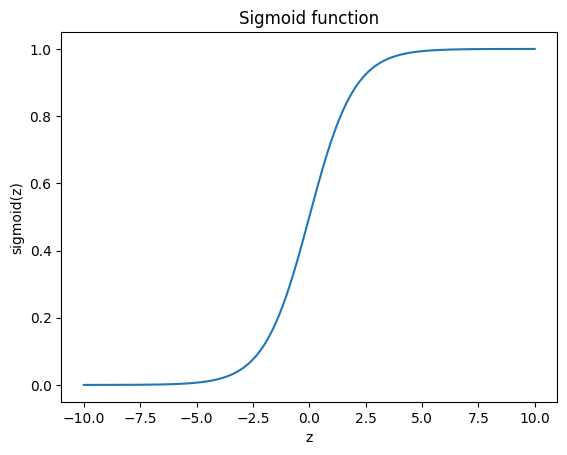

In [3]:
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, [sigma(x) for x in xx])
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.title("Sigmoid function");

Обозначим $P(X)$ вероятностью происходящего события $X$. Тогда отношение вероятностей $OR(X)$ определяется из $\frac{P(X)}{1-P(X)}$, а это — отношение вероятностей того, произойдет ли событие или не произойдет. Очевидно, что вероятность и отношение шансов содержат одинаковую информацию. Но в то время как $P(X)$ находится в пределах от 0 до 1, $OR(X)$ находится в пределах от 0 до $\infty$.

Если вычислить логарифм $OR(X)$ (то есть называется логарифм шансов, или логарифм отношения вероятностей), то легко заметить, что $\log{OR(X)} \in \mathbb{R}$. Его то мы и будем прогнозировать с помощью МНК.

Посмотрим, как логистическая регрессия будет делать прогноз $p_+ = \text{P}\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right)$ (пока считаем, что веса $\textbf{w}$ мы как-то получили (т.е. обучили модель), далее разберемся, как именно).

**Шаг 1.** Вычислить значение $w_{0}+w_{1}x_1 + w_{2}x_2 + ... = \textbf{w}^\text{T}\textbf{x}$. (уравнение $\textbf{w}^\text{T}\textbf{x} = 0$ задает гиперплоскость, разделяющую примеры на 2 класса);


**Шаг 2.** Вычислить логарифм отношения шансов: $ \log(OR_{+}) =  \textbf{w}^\text{T}\textbf{x}$.

**Шаг 3.** Имея прогноз шансов на отнесение к классу "+" – $OR_{+}$, вычислить $p_{+}$ с помощью простой зависимости:

$$\Large p_{+} = \frac{OR_{+}}{1 + OR_{+}} = \frac{\exp^{\textbf{w}^\text{T}\textbf{x}}}{1 + \exp^{\textbf{w}^\text{T}\textbf{x}}} =  \frac{1}{1 + \exp^{-\textbf{w}^\text{T}\textbf{x}}} = \sigma(\textbf{w}^\text{T}\textbf{x})$$


В правой части мы получили как раз сигмоид-функцию.

Итак, логистическая регрессия прогнозирует вероятность отнесения примера к классу "+" (при условии, что мы знаем его признаки и веса модели) как сигмоид-преобразование линейной комбинации вектора весов модели и вектора признаков примера:

$$\Large p_+(x_i) = \text{P}\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right) = \sigma(\textbf{w}^\text{T}\textbf{x}_\text{i}). $$

Следующий вопрос: как модель обучается. Тут мы опять обращаемся к принципу максимального правдоподобия.

### Принцип максимального правдоподобия и логистическая регрессия
Теперь посмотрим, как из принципа максимального правдоподобия получается оптимизационная задача, которую решает логистическая регрессия, а именно, – минимизация *логистической* функции потерь.
Только что мы увидели, что логистическая регрессия моделирует вероятность отнесения примера к классу "+" как

$$\Large p_+(\textbf{x}_\text{i}) = \text{P}\left(y_i = 1 \mid \textbf{x}_\text{i}, \textbf{w}\right) = \sigma(\textbf{w}^\text{T}\textbf{x}_\text{i})$$

Тогда для класса "-" аналогичная вероятность:
$$\Large p_-(\textbf{x}_\text{i})  = \text{P}\left(y_i = -1 \mid \textbf{x}_\text{i}, \textbf{w}\right)  = 1 - \sigma(\textbf{w}^\text{T}\textbf{x}_\text{i}) = \sigma(-\textbf{w}^\text{T}\textbf{x}_\text{i}) $$

Оба этих выражения можно ловко объединить в одно (следите за моими руками – не обманывают ли вас):

$$\Large \text{P}\left(y = y_i \mid \textbf{x}_\text{i}, \textbf{w}\right) = \sigma(y_i\textbf{w}^\text{T}\textbf{x}_\text{i})$$

Выражение $M(\textbf{x}_\text{i}) = y_i\textbf{w}^\text{T}\textbf{x}_\text{i}$ называется *отступом* (*margin*) классификации на объекте $\textbf{x}_\text{i}$ (не путать с зазором (тоже margin), про который чаще всего говорят в контексте SVM). Если он неотрицателен, модель не ошибается на объекте $\textbf{x}_\text{i}$, если же отрицателен – значит, класс для $\textbf{x}_\text{i}$  спрогнозирован неправильно.
Заметим, что отступ определен для объектов именно обучающей выборки, для которых известны реальные метки целевого класса $y_i$.

Чтобы понять, почему это мы сделали такие выводы, обратимся к геометрической интерпретации линейного классификатора. Подробно про это можно почитать в материалах Евгения Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem09_linear.pdf).

Рекомендую решить почти классическую задачу из начального курса линейной алгебры: найти расстояние от точки с радиус-вектором $\textbf{x}_A$ до плоскости, которая задается уравнением $\textbf{w}^\text{T}\textbf{x} = 0.$


Ответ:
$\Large \rho(\textbf{x}_A, \textbf{w}^\text{T}\textbf{x} = 0) = \frac{\textbf{w}^\text{T}\textbf{x}_A}{||\textbf{w}||}$


<img src = '../../img/simple_linal_task.png' width=60%>

Когда получим (или посмотрим) ответ, то поймем, что чем больше по модулю выражение $\textbf{w}^{\text{T}}\textbf{x}_\text{i}$, тем дальше точка $\textbf{x}_\text{i}$ находится от плоскости $\textbf{w}^{\text{T}}\textbf{x} = 0.$

Значит, выражение $M(\textbf{x}_\text{i}) = y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}$ – это своего рода "уверенность" модели в классификации объекта $\textbf{x}_\text{i}$:

- если отступ большой (по модулю) и положительный, это значит, что метка класса поставлена правильно, а объект находится далеко от разделяющей гиперплоскости (такой объект классифицируется уверенно). На рисунке – $x_3$.
- если отступ большой (по модулю) и отрицательный, значит метка класса поставлена неправильно, а объект находится далеко от разделюящей гиперплоскости (скорее всего такой объект – аномалия, например, его метка в обучающей выборке поставлена неправильно). На рисунке – $x_1$.
- если отступ малый (по модулю), то объект находится близко к разделюящей гиперплоскости, а  знак отступа определяет, правильно ли объект классифицирован.  На рисунке – $x_2$ и $x_4$.

<img src = '../../img/margin.png' width=60%>

Теперь распишем правдоподобие выборки, а именно, вероятность наблюдать данный вектор $\textbf{y}$ у выборки $\textbf X$. Делаем сильное предположение: объекты приходят независимо, из одного распределения (*i.i.d.*). Тогда

$$\Large \text{P}\left(\textbf{y} \mid \textbf X, \textbf{w}\right) = \prod_{i=1}^{\ell} \text{P}\left(y = y_i \mid \textbf{x}_\text{i}, \textbf{w}\right),$$

где $\ell$ – длина выборки $\textbf X$ (число строк).

Как водится, возьмем логарифм данного выражения (сумму оптимизировать намного проще, чем произведение):

$$\Large  \log \text{P}\left(\textbf{y} \mid \textbf X, \textbf{w}\right) = \log \sum_{i=1}^{\ell} \text{P}\left(y = y_i \mid \textbf{x}_\text{i}, \textbf{w}\right) = \log \prod_{i=1}^{\ell} \sigma(y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i})   = $$

$$\Large  = \sum_{i=1}^{\ell} \log \sigma(y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}) = \sum_{i=1}^{\ell} \log \frac{1}{1 + \exp^{-y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}}} = - \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}})$$

То есть в данном случае принцип максимизации правдоподобия приводит к минимизации выражения

$$\Large \mathcal{L_{log}} (\textbf X, \textbf{y}, \textbf{w}) = \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}}).$$

Это *логистическая* функция потерь, просуммированная по всем объектам обучающей выборки.

Посмотрим на новую фунцию как на функцию от отступа: $L(M) = \log (1 + \exp^{-M})$. Нарисуем ее график, а также график 1/0 функциий потерь (*zero-one loss*), которая просто штрафует модель на 1 за ошибку на каждом объекте (отступ отрицательный): $L_{1/0}(M) = [M < 0]$.

<img src = '../../img/logloss_margin.png' width=60%>

Картинка отражает общую идею, что в задаче классификации, не умея напрямую минимизировать число ошибок (по крайней мере, градиентными методами это не сделать – производная 1/0 функциий потерь в нуле обращается в бесконечность), мы минимизируем некоторую ее верхнюю оценку. В данном случае это логистическая функция потерь (где логарифм двоичный, но это не принципиально), и справедливо

$$\Large \mathcal{L_{\text{1/0}}} (\textbf X, \textbf{y}, \textbf{w}) = \sum_{i=1}^{\ell} [M(\textbf{x}_\text{i}) < 0] \leq \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}}) = \mathcal{L_{\log}} (\textbf X, \textbf{y}, \textbf{w}), $$

где $\mathcal{L_{\text{1/0}}} (\textbf X, \textbf{y}, \textbf{w})$ – попросту число ошибок логистической регрессии с весами $\textbf{w}$ на выборке $(\textbf X, \textbf{y})$.

То есть уменьшая верхнюю оценку $\mathcal{L_{\log}}$ на число ошибок классификации, мы таким образом надеемся уменьшить и само число ошибок.

### L2-регуляризация логистической функции потерь

$L2-регуляризация$ логистической регрессии устроена почти так же, как и в случае с гребневой (Ridge регрессией). Вместо функционала $\mathcal{L_{\log}} (X, \textbf{y}, \textbf{w})$ минимизируется следующий:

$$\Large J(\textbf X, \textbf{y}, \textbf{w}) = \mathcal{L_{\log}} (\textbf X, \textbf{y}, \textbf{w}) + \lambda |\textbf{w}|^2$$

В случае логистической регрессии принято введение обратного коэффициента регуляризации $C = \frac{1}{\lambda}$. И тогда решением задачи будет

$$\Large \widehat{\textbf{w}}  = \arg \min_{\textbf{w}} J(\textbf X, \textbf{y}, \textbf{w}) =  \arg \min_{\textbf{w}}\ (C\sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\textbf{w}^{\text{T}}\textbf{x}_\text{i}})+ |\textbf{w}|^2)$$

Далее рассмотрим пример, позволяющий интуитивно понять один из смыслов регуляризации.